In [ ]:
# 将所有的csv合并在一起。
import os
import pandas as pd

# 设置文件夹路径和输出文件名
folder_path = '/data1/dxw_data/llm/redbook_final/data/red_02/good'  # 替换为你的文件夹路径
# good文件夹里面是:
# 02_post_data_2024-06-16.csv
# 02_post_data_2024-06-17.csv
# 02_post_data_2024-06-18.csv
# 02_post_data_2024-06-19.csv
# 02_post_data_2024-06-20.csv
# 02_post_data_2024-06-21.csv
# 02_post_data_2024-06-22.cs
# 02_post_data_2024-06-23.csv
# 02_post_data_2024-06-24.csv
# 02_post_data_2024-06-25.csv
# 02_post_data_2024-06-26.csv
# 02_post_data_2024-06-27.csv
# 02_post_data_2024-06-28.csv
# 02_post_data_2024-06-29.csv
# 02_post_data_2024-06-30.csv
# 02_post_data_2024-07-01.csv
# 02_post_data_2024-07-02.csv
# 02_post_data_2024-07-03.csv
output_file = '/data1/dxw_data/llm/redbook_final/data/red_02/merged_good_raw.csv'  # 替换为你想要输出的文件名

# 创建一个空的列表来存储所有数据
all_data_frames = []

# 遍历文件夹中的所有CSV文件
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # 读取CSV文件并追加到列表中
        df = pd.read_csv(file_path)
        all_data_frames.append(df)

# 将所有数据框合并到一个大的数据框中
merged_df = pd.concat(all_data_frames, ignore_index=True)

# 将合并后的数据保存到一个新的CSV文件中
merged_df.to_csv(output_file, index=False)

print(f'所有文件已合并到 {output_file}')

#! 里面有些行看起来有问题，但是其实都是对的，不用管。


/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warning

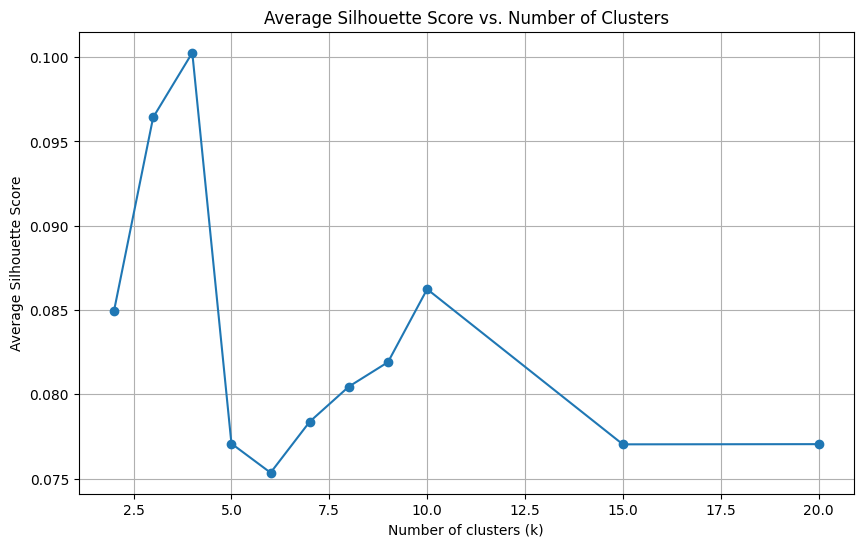

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images: 100%|██████████| 19367/19367 [00:07<00:00, 2611.96it/s]

Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/data3/combined_seg_img_cluster_imagebind_silhouette


In [1]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind import data
from PIL import Image
from torchvision import transforms
import shutil
from tqdm import tqdm

# Paths
input_folder = '/data1/dxw_data/llm/redbook_final/data3/combined_seg_img'
output_folder = '/data1/dxw_data/llm/redbook_final/data3/combined_seg_img_cluster_imagebind_silhouette'
os.makedirs(output_folder, exist_ok=True)

# Device setup
device = "cuda:4" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load image paths
image_paths = [os.path.join(input_folder, fname) for fname in os.listdir(input_folder) if fname.endswith('.png')]

# Function to load and transform a batch of images
def load_images_batch(image_paths_batch):
    images = [transform(Image.open(path).convert('RGB')) for path in image_paths_batch]
    return torch.stack(images).to(device)

# Batch size
batch_size = 32  # Adjust based on your GPU memory

# Generate embeddings in batches
all_embeddings = []
for i in tqdm(range(0, len(image_paths), batch_size), desc="Generating embeddings"):
    batch_paths = image_paths[i:i + batch_size]
    images_tensor = load_images_batch(batch_paths)
    with torch.no_grad():
        embeddings = model({ModalityType.VISION: images_tensor})
    all_embeddings.append(embeddings[ModalityType.VISION].cpu())
    torch.cuda.empty_cache()  # Clear cache to free memory

# Concatenate all embeddings
all_embeddings = torch.cat(all_embeddings, dim=0)

# Determine optimal number of clusters using Average Silhouette Method
silhouette_scores = []
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]  # Discrete values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(all_embeddings.numpy())
    score = silhouette_score(all_embeddings.numpy(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(all_embeddings.numpy())

# Save clustered images to output folders
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    shutil.copy(image_paths[idx], os.path.join(label_folder, os.path.basename(image_paths[idx])))

# Save labels to JSON
labels_json = {os.path.basename(image_paths[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                
print(f'Clustering complete. Output saved to {output_folder}')


/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warning

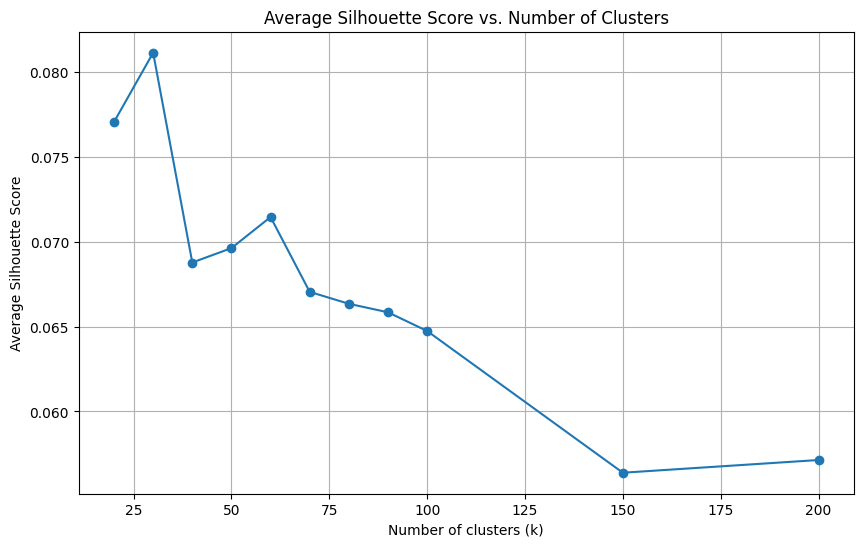

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images: 100%|██████████| 19367/19367 [00:08<00:00, 2392.86it/s]

Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/data3/combined_seg_img_cluster_imagebind_silhouette


In [1]:
import os
import json
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind import data
from PIL import Image
from torchvision import transforms
import shutil
from tqdm import tqdm

# Paths
input_folder = '/data1/dxw_data/llm/redbook_final/data3/combined_seg_img'
output_folder = '/data1/dxw_data/llm/redbook_final/data3/combined_seg_img_cluster_imagebind_silhouette'
os.makedirs(output_folder, exist_ok=True)

# Device setup
device = "cuda:2" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load image paths
image_paths = [os.path.join(input_folder, fname) for fname in os.listdir(input_folder) if fname.endswith('.png')]

# Function to load and transform a batch of images
def load_images_batch(image_paths_batch):
    images = [transform(Image.open(path).convert('RGB')) for path in image_paths_batch]
    return torch.stack(images).to(device)

# Batch size
batch_size = 32  # Adjust based on your GPU memory

# Generate embeddings in batches
all_embeddings = []
for i in tqdm(range(0, len(image_paths), batch_size), desc="Generating embeddings"):
    batch_paths = image_paths[i:i + batch_size]
    images_tensor = load_images_batch(batch_paths)
    with torch.no_grad():
        embeddings = model({ModalityType.VISION: images_tensor})
    all_embeddings.append(embeddings[ModalityType.VISION].cpu())
    torch.cuda.empty_cache()  # Clear cache to free memory

# Concatenate all embeddings
all_embeddings = torch.cat(all_embeddings, dim=0)

# Determine optimal number of clusters using Average Silhouette Method
silhouette_scores = []
k_values = [20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]  # Discrete values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(all_embeddings.numpy())
    score = silhouette_score(all_embeddings.numpy(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(all_embeddings.numpy())

# Save clustered images to output folders
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    shutil.copy(image_paths[idx], os.path.join(label_folder, os.path.basename(image_paths[idx])))

# Save labels to JSON
labels_json = {os.path.basename(image_paths[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)
                                                                                               
print(f'Clustering complete. Output saved to {output_folder}')


/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of

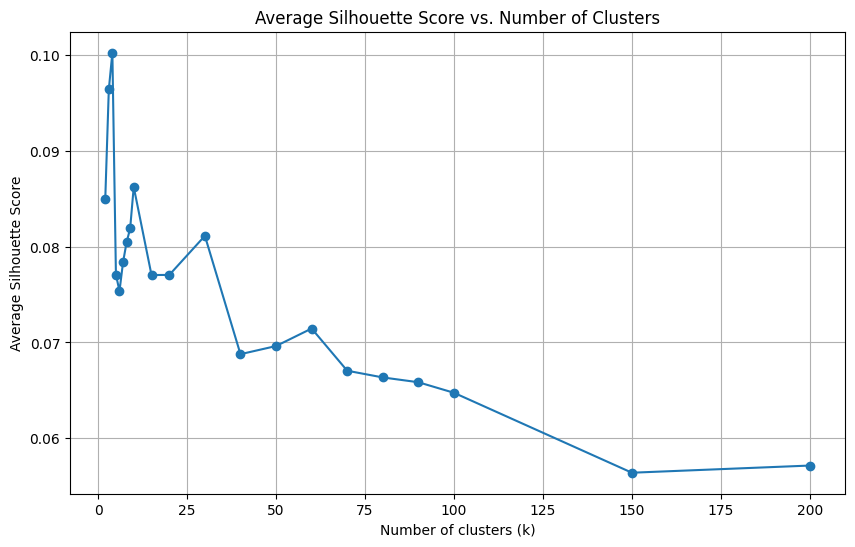

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Saving clustered images: 100%|██████████| 19367/19367 [00:56<00:00, 341.20it/s]


Clustering complete. Output saved to /data1/dxw_data/llm/redbook_final/data3/combined_seg_img_cluster_imagebind_silhouette


In [3]:


# Determine optimal number of clusters using Average Silhouette Method
silhouette_scores = []
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]  # Discrete values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(all_embeddings.numpy())
    score = silhouette_score(all_embeddings.numpy(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(all_embeddings.numpy())

# Save clustered images to output folders
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    shutil.copy(image_paths[idx], os.path.join(label_folder, os.path.basename(image_paths[idx])))

# Save labels to JSON
labels_json = {os.path.basename(image_paths[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)
                                                                                               
print(f'Clustering complete. Output saved to {output_folder}')

In [4]:
# Determine optimal number of clusters using Elbow Method
wcss = []
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]  # Discrete values for k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(all_embeddings.numpy())
    wcss.append(kmeans.inertia_)

# Plot WCSS scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()

# Select optimal k (example: based on elbow point)
optimal_k = 5  # Replace with chosen optimal k based on the elbow plot

# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(all_embeddings.numpy())

# Save clustered images to output folders
for idx, label in tqdm(enumerate(labels), desc="Saving clustered images", total=len(labels)):
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    shutil.copy(image_paths[idx], os.path.join(label_folder, os.path.basename(image_paths[idx])))

# Save labels to JSON
labels_json = {os.path.basename(image_paths[idx]): int(label) for idx, label in enumerate(labels)}
with open(os.path.join(output_folder, 'labels.json'), 'w') as f:
    json.dump(labels_json, f)

print(f'Clustering complete. Output saved to {output_folder}')

/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dxw/anaconda3/envs/agent/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of